This is a jupyter notebook where we discover and try to delete outliers for EEG.

In [115]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load libraries

In [116]:
%autoreload

# load libraries
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings

In [117]:
# read the dataset
dataset = pd.read_csv('../../dataset/dataset.csv')

# define features and target variables
# X = dataset.filter(regex=r'V\d+')             # take just EEG columns
X = dataset.drop(columns=['score', 'tempMean', 'tempSD'])        
# X = dataset.drop(columns=['score'])
y = dataset['score']


In [118]:
# check dataframes' shape
print(dataset.shape)
print(X.shape)
print(y.shape)

# check columns of X
print(X.columns)

(192, 90)
(192, 89)
(192,)
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41',
       'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51',
       'numFix', 'numSac', 'ratioFixSac', 'meanPupil', 'sdPupil', 'meanFixDur',
       'sdFixDur', 'meanSacVel', 'sdSacVel', 'meanSacAmp', 'sdSacAmp',
       'scanpathVel', 'infoProcess', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'bvpMean',
       'bvpSD', 'edaMean', 'edaSD', 'hrMean', 'hrSD', 'tempMean', 'tempSD'],
      dtype='object')


In [119]:
# Split the dataset into training and testing part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Feature engineering

In [138]:
def divideDataFrame(df: pd.DataFrame, regex_pattern: str) -> (pd.DataFrame, pd.DataFrame):
    df_matching = df.filter(regex=regex_pattern)
    df_not_matching = df.loc[:, ~df.columns.isin(df_matching.columns)]
    return df_matching, df_not_matching

def findOutliersUsingIQR(X: pd.DataFrame, bounds: float) -> pd.DataFrame:
    # find outliers using Interquartile range (IQR)
    outliers = pd.DataFrame(columns=X.columns)      # initialize an empty dataframe
    EEG_columns = dataset.filter(regex=r'V\d+')             # take just EEG columns
    for target_variable in EEG_columns:
        Q1 = X[target_variable].quantile(0.25)
        Q3 = X[target_variable].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - bounds * IQR
        upper_bound = Q3 + bounds * IQR

        # Identify outliers
        new_outliers = X[(X[target_variable] < lower_bound) | (X[target_variable] > upper_bound)]
        outliers = pd.concat([outliers, new_outliers]).drop_duplicates()
    return outliers


def removeOutliers(X: pd.DataFrame, y: pd.DataFrame, outliers: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    return X.drop(outliers.index), y.drop(outliers.index)


def normalizeData(X: pd.DataFrame) -> pd.DataFrame:
    # normalize data
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    return X_normalized
    

def reduceEEG(X: pd.DataFrame, concat_wavelengths: bool) -> pd.DataFrame:
    if concat_wavelengths:
        # concatenate wave lengths
        column_names = [[] for _ in range(3)]
        for i in range(51):
            column_names[i%3].append(f"V{i+1}")
    else:    
        # concatenate places
        column_names = [[] for _ in range(17)]
        for i in range(51):
            column_names[i//3].append(f"V{i+1}")

    X_EEG, X_not_EEG = divideDataFrame(X, regex_pattern=r'V\d+')
    column_groups = [X_EEG[names] for names in column_names]
    ##means = [group.mean(axis=1) for group in column_groups]
    ##X_reduction_EEG = pd.DataFrame({f'EEG_mean{i+1}': means[i] for i in range(len(column_groups))})
    
    ## Using PCA for dimensions reduction.
    
    new_dimensions = []
    
    for column_group in column_groups:
        pca = PCA()
        pca.fit(column_group)
        n_axes = 1
        pca.n_components = n_axes
        reduced_column = pca.transform(column_group)[:, 0]
        
        new_dimensions.append(reduced_column)
    new_dimensions = np.array(new_dimensions).T
        
    X_reduction_EEG = pd.DataFrame({f'EEG_reduced{i+1}' : new_dimensions[:, i] for i in range(len(column_groups))})
    
    X_result = pd.concat([X_reduction_EEG, X_not_EEG], axis=1)
    # print(X_result.columns)

    return X_result


def transformFacialVideo(X: pd.DataFrame) -> pd.DataFrame:
    # feature engineering: convert facial expressions to emotions (according to 
    # https://imotions.com/blog/learning/research-fundamentals/facial-action-coding-system/#head-movement-action-units)

    X_facial, X_not_facial = divideDataFrame(X, regex_pattern=r'AU\d+')

    X_emotions = pd.DataFrame({
        "joy": X_facial[["AU06_r", "AU12_r"]].mean(axis=1),
        "sadness": X_facial[["AU01_r", "AU04_r", "AU15_r"]].mean(axis=1),
        "surprise": X_facial[["AU01_r", "AU02_r", "AU05_r", "AU26_r"]].mean(axis=1),                       
        "fear": X_facial[["AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU07_r", "AU20_r", "AU26_r"]].mean(axis=1),
        "anger": X_facial[["AU04_r", "AU05_r", "AU07_r", "AU23_r"]].mean(axis=1),
        "disgust": X_facial[["AU09_r", "AU15_r", "AU25_r"]].mean(axis=1), # there should be AU16_r instead of 
        # AU25_r, but the dataset does not contain AU16_r and AU25_r should be correlated with AU16_r
        "contempt": X_facial[["AU12_r", "AU14_r"]].mean(axis=1)
    })
    X_result = pd.concat([X_emotions, X_not_facial], axis=1)
    return X_result


In [139]:
# # print box plots before removing outliers
# for column in X:
#     plt.figure()
#     plt.boxplot(X[column])

# # print correlation matrix to file before removing outliers
# with open('original_features.html', 'w') as f:
#     print(X.corr().abs().style.background_gradient().to_html(), file=f)

# # show correlation matrix before removing outliers
# px.imshow(X.corr(),title="NTNU dataset")

In [140]:
X_modified, y_modified = X_train.copy(), y_train.copy()

# order of these operations might result in different outcome
# remove outliers
outliers = findOutliersUsingIQR(X_modified, bounds=7.)
X_modified, y_modified = removeOutliers(X_modified, y_modified, outliers)

# reduce EEG
X_modified = reduceEEG(X_modified, concat_wavelengths=True)

# transform facial video
X_modified = transformFacialVideo(X_modified)

# normalize
X_modified = normalizeData(X_modified)

/tmp/ipykernel_89901/1738843095.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers = pd.concat([outliers, new_outliers]).drop_duplicates()


X[X.isna().any(axis=1)] = Empty DataFrame
Columns: [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51]
Index: []

[0 rows x 51 columns]
X[X.isna().any(axis=1)] = Empty DataFrame
Columns: [EEG_reduced1, EEG_reduced2, EEG_reduced3]
Index: []


/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

## Predict

In [141]:
# Define the model
model = DecisionTreeRegressor(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mean absolute error
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

print(f"mean absolute error = {mae}")

mean absolute error = 0.503073192809242


/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/karel/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

## Crossvalidation

In [142]:
def crossvalidate(X: pd.DataFrame,
                  y: pd.DataFrame,
                  n_estimators: [int], 
                  outliers_bounds: [int], 
                  random_states: [int]) -> np.array:
    results = np.zeros((len(outliers_bounds), len(n_estimators), 1, 1))
    for i, outlier_bound in enumerate(outliers_bounds):                         # hyperparameter for deleting outliers
        for j, n_estimator in enumerate(n_estimators):                          # hyperparameter for decision forests
            for k, concat_wavelength in enumerate([True]):         # hyperparameter for EEG feature engineering
                for l, transform_facial in enumerate([True]):            # hyperparameter for facial video feature engineering
                    for random_state in random_states:                          # calculate MAE through different train-validation splits and average out the result
                        X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=random_state)
                        X_modified, y_modified = X_train.copy(), y_train.copy()

                        outliers = findOutliersUsingIQR(X_modified, bounds=outlier_bound)
                        X_modified, y_modified = removeOutliers(X_modified, y_modified, outliers)
                        if concat_wavelength != None:
                            X_modified = reduceEEG(X_modified, concat_wavelengths=concat_wavelength)
                            X_validation = reduceEEG(X_validation, concat_wavelengths=concat_wavelength)
                        if transform_facial:
                            X_modified = transformFacialVideo(X_modified)
                            X_validation = transformFacialVideo(X_validation)
                        # X_modified = normalizeData(X_modified)

                        # model = RandomForestRegressor(n_estimators=n_estimator, random_state=42)
                        model = DecisionTreeRegressor(random_state=42)
                        model.fit(X_modified, y_modified)
                        y_pred = model.predict(X_validation)
                        mae = mean_absolute_error(y_true=y_validation, y_pred=y_pred)
                        print(f"bound: {outlier_bound}\t outliers: {(1 - len(X_modified)/len(X_train))*100:.3f}%\t "
                            f"n_est: {n_estimator}\t concat_wavel: {concat_wavelength}\t face_trans: {transform_facial}\t"
                            f"mae = {mae:.3f}")
                        results[i][j][k][l] += mae / len(random_states)
    return results

def getIndexWithMinValue(values: np.ndarray) -> [int]:
    max_index = np.unravel_index(np.argmin(values), values.shape)
    return max_index

In [143]:
# WARNING: this section takes about 20 minutes to execute

# Split the data into training, validation, and testing sets
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69)

# samples for crossvalidation
n_estimators = [10, 30, 70, 100]                                    # hyperparameter for decision forest
n_estimators = [1]
outliers_bounds = [1.5, 3, 4.5, 6, 7.5, 9., 10.5, 100, 10000]       # hyperparameter for determining outliers
random_states = [42, 69, 169, 1000]                                 # hyperparameter for splitting the dataset to train and validation
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    crossval_score = crossvalidate(X_train, y_train, n_estimators, outliers_bounds, random_states)
    print(crossval_score)

X[X.isna().any(axis=1)] = Empty DataFrame
Columns: [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51]
Index: []

[0 rows x 51 columns]
X[X.isna().any(axis=1)] = Empty DataFrame
Columns: [EEG_reduced1, EEG_reduced2, EEG_reduced3]
Index: []
X[X.isna().any(axis=1)] = Empty DataFrame
Columns: [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51]
Index: []

[0 rows x 51 columns]
X[X.isna().any(axis=1)] = Empty DataFrame
Columns: [EEG_reduced1, EEG_reduced2, EEG_reduced3]
Index: []


ValueError: Input X contains NaN.
DecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# this part shows mean absolute error for each parameter tweak in crossvalidation averaged out through all runs of crossvalidation
print(f"marginal results: \n"
      f"\tbounds\t {outliers_bounds}:\t{np.mean(crossval_score, axis=(1, 2, 3))}\n"
      f"\tn_estimators\t {n_estimators}:\t{np.mean(crossval_score, axis=(0, 2, 3))}\n"
      f"\tconcat_wavelengths\t [False, True, None]: {np.mean(crossval_score, axis=(0, 1, 3))}\n"
      f"\ttransform_facial\t [False, True]: {np.mean(crossval_score, axis=(0, 1, 2))}\n")
print(f"minimum score from crossvalidation: {crossval_score[getIndexWithMinValue(crossval_score)]}\n"
      f"index: {getIndexWithMinValue(crossval_score)}")

# It seems like the feature engineering did not help much :( but at least it improved the interpretability of the dataset

marginal results: 
	bounds	 [1.5, 3, 4.5, 6, 7.5, 9.0, 10.5, 100, 10000]:	[1.06361951 0.79871168 0.79429608 0.63326102 0.6161186  0.61674847
 0.61780952 0.49675608 0.45873593]
	n_estimators	 [1]:	[0.67733965]
	concat_wavelengths	 [False, True, None]: [0.66245678 0.68793622 0.68162596]
	transform_facial	 [False, True]: [0.67836844 0.67631087]

minimum score from crossvalidation: 0.4213129303208548
index: (8, 0, 2, 1)


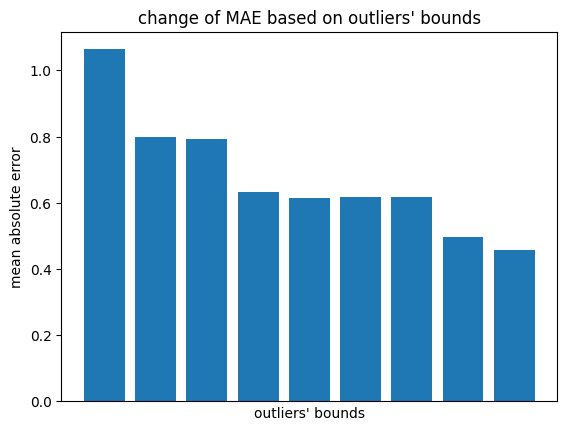

In [ ]:
# Plot the array as columns

plt.bar(np.arange(crossval_score.shape[0]), np.mean(crossval_score, axis=(1, 2, 3)), width=0.8)
# for i, bound in enumerate(outliers_bounds):
#     plt.text(i, -0.01, str(bound), ha="center", va="top")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.xlabel("outliers' bounds")
plt.ylabel("mean absolute error")
plt.title("change of MAE based on outliers' bounds")
plt.xticks()
plt.show()

In [ ]:
# evaluate the best result from crossvalidation on real data
min_crossval_score_id = getIndexWithMinValue(crossval_score)
opt_bounds = outliers_bounds[min_crossval_score_id[0]]
opt_n_estimators = n_estimators[min_crossval_score_id[1]]
opt_concat_wavelength = [False, True, None][min_crossval_score_id[2]]
opt_transform_facial = min_crossval_score_id[3]

X_modified, y_modified = X_train.copy(), y_train.copy()
outliers = findOutliersUsingIQR(X_modified, bounds=opt_bounds)
X_modified, y_modified = removeOutliers(X_modified, y_modified, outliers)
if opt_concat_wavelength != None:
    X_modified = reduceEEG(X_modified, concat_wavelengths=opt_concat_wavelength)
    # X_test = reduceEEG(X_test, concat_wavelengths=opt_concat_wavelength)
if opt_transform_facial:
    X_modified = transformFacialVideo(X_modified)
    # X_test = transformFacialVideo(X_test)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # model = RandomForestRegressor(random_state=42, n_estimators=opt_n_estimators)
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_modified, y_modified)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

print(f"mean absolute error: {mae}")            # mean absolute error: 0.3
# not the best model apparently, but I could not find a better one

mean absolute error: 0.379791963913012


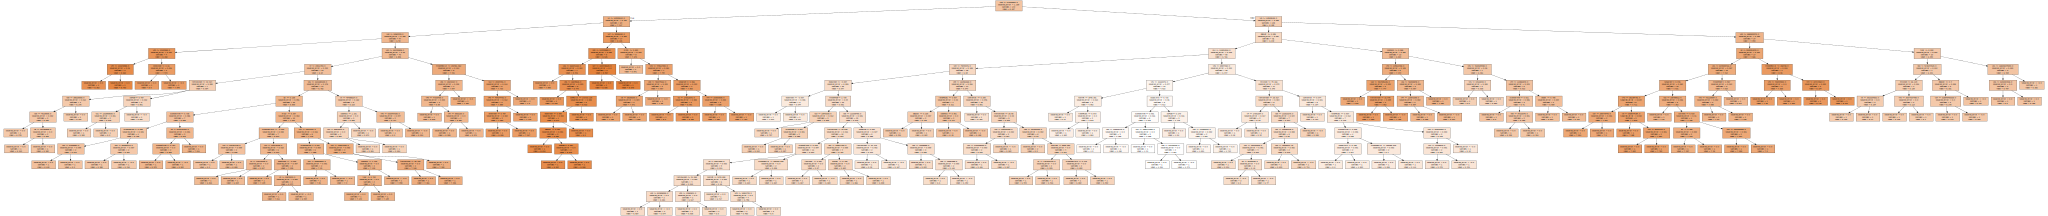

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, feature_names=X_modified.columns, filled=True)
graph = graphviz.Source(dot_data, format="png")
graph.render("regression_tree")
graph